In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from IPython.display import HTML
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import seaborn as sns

In [2]:
# importation des données brutes en utilisant les productid comme index

data_path = "../data/raw/"
df = pd.read_csv(data_path+"X_train_update.csv", index_col="productid").drop("Unnamed: 0", axis=1)
y = pd.read_csv(data_path+"Y_train_CVw08PX.csv")['prdtypecode']
y.index = df.index

In [3]:
# on créer une colonne avec le chemin de l'image correspondante

im_folder_path = data_path+"images/image_train/"
# les noms de fichier image sont de la forme image_imageid_product_productid.jpg
df['image'] = im_folder_path + 'image_' + df['imageid'].astype('str') + '_product_' + df.index.astype('str') +'.jpg'
# plus nécessaire de garder imageid qui est renseigné dans le chemin
df.drop('imageid', axis=1, inplace=True)

In [4]:
# fonction qui permet d'afficher les images du dataframe à partir du chemin des images
# et également les descriptions complètent
# attention de ne pas utiliser max_length trop grand sinon ça va être long à charger

def display_df(df, max_length = 100):
    formatters={
        "image": lambda path: f'<img src="{path}" width="400">',
    }
    display(HTML(df.head(max_length).to_html(escape=False, formatters=formatters)))

In [5]:
# max_load représente le nombre d'octet maxixum chargé en mémoire 10**8 => 100 Mo
# le nombre d'images retourner se fera en fonction de ce paramètre

def images_read(impath, dsize=(150,150), grayscale=True, max_load=10**8):
    n = len(impath)
    total_size = n*dsize[0]*dsize[1] if grayscale else n*dsize[0]*dsize[1]*3
    stop = int(n * (max_load/total_size)) if total_size > max_load else n
    images = []
    if grayscale:
        for i in range(stop):
            im = cv2.imread(impath.iloc[i], cv2.IMREAD_GRAYSCALE)
            images.append(cv2.resize(im, dsize = dsize))
    else:
        for i in range(stop):
            im = cv2.imread(impath.iloc[i], cv2.IMREAD_COLOR)
            # cv2 encodes les images aux formats BGR,
            # on les transforme en RGB pour les afficher correctement avec matplotlib 
            im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
            images.append(cv2.resize(im, dsize = dsize))
    return np.array(images)

In [6]:
# images = images_read(df['image'], max_load=2*10**9) # permet de charger toute les images mais un peut long à tourner
# images = images.reshape((images.shape[0], images.shape[1]*images.shape[2]))

In [7]:
# fonction prise telle quelle du module "Méthodes de réduction de dimension - Manifold learning"

from matplotlib import offsetbox

def plot_components(data, model, images=None, ax=None,
                    thumb_frac=0.05, cmap='gray_r', prefit = False):
    ax = ax or plt.gca()
    
    if not prefit :
        proj = model.fit_transform(data)
    else:
        proj = data
    ax.plot(proj[:, 0], proj[:, 1], '.b')
    
    if images is not None:
        min_dist_2 = (thumb_frac * max(proj.max(0) - proj.min(0))) ** 2
        shown_images = np.array([2 * proj.max(0)])
        for i in range(data.shape[0]):
            dist = np.sum((proj[i] - shown_images) ** 2, 1)
            if np.min(dist) < min_dist_2:
                # On ne montre pas le points trop proches
                continue
            shown_images = np.vstack([shown_images, proj[i]])
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(cv2.resize(images[i], dsize = (28,28)), cmap=cmap),
                                      proj[i])
            ax.add_artist(imagebox)

In [8]:
N = 5000
im28x28 = images_read(df['image'].iloc[:N], dsize=(28,28), max_load=2*10**9)
im28x28 = im28x28.reshape((im28x28.shape[0], im28x28.shape[1]*im28x28.shape[2]))
lda = LinearDiscriminantAnalysis(n_components=2)
lda.fit(im28x28[:N], y[:N])
imt = lda.transform(im28x28[:N])

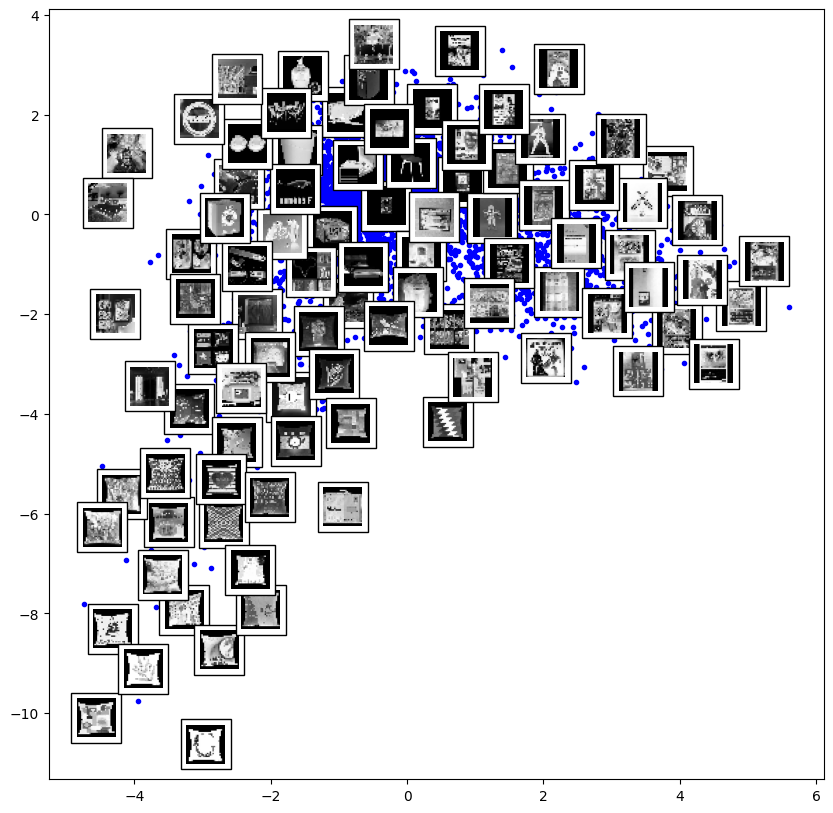

In [9]:
fig, ax = plt.subplots(figsize=(10, 10))
plot_components(imt, lda, im28x28[:N].reshape((-1,28,28)), prefit=True, ax=ax, thumb_frac=0.05)


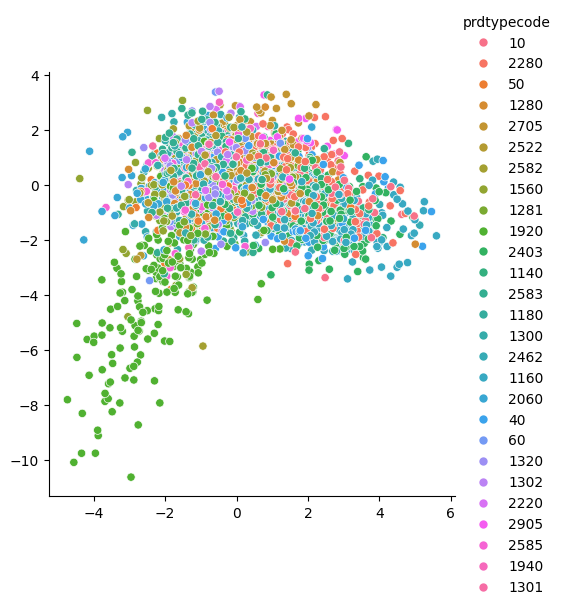

In [10]:
sns.relplot(x=imt[:,0], y=imt[:,1], hue=y[:N].astype('str'))

# seul la catégorie 1920 semble facilement se démarquer (en bas à gauche)  avec la LDA en deux dimensions
# (essentiellement les coussins / oreillets comme on le voit au dessus)
# à doite on voit des objet plus rectangulaire ressemblant à des livres / posters / boite de jeu
# qui sont surement représenter dans plein de catégorie
# pas évident de voir ce que ces axes peuvent représenter

In [11]:
# exemple; on affiche les 5 premières entrées de la catégorie 2583

cat = 1920
display_df(df[y == cat], 10)

# à priori les coussins peuvent facilement se démarquer par l'image mais également par la description / designation

,designation,description,image
productid,,,
1882164320,Paire De Voilages Imprimés Fantaisie,Paire de voilages droits fantaisie qui mettra votre intérieur en valeurUn parement uni à petits coeurs suivi d'un petit galon coloré en forme également de coeur qui viendra faire la jonction avec la partie inférieure rayée ton sur ton en coloris écru2 coloris: gris et rouge2 dimensions: 60 x 120 cm et 60 x 160 cmFinition de tête a ourlet passe tringlePrêt-à-poserLa base et les côtés sont ourlés Caractéristiques:Coloris: gris et rougeFinition: ourlet à passe tringleComposition: 73% polyester et 27% cotonDimensions: 60 x 120 cm et 60 x 160 cm Vendu à la pairePrêt-à-poser,
4012748163,4pcs Décor Coussin Indépendance Style Jeter Covers Taie D'oreiller,"4pcs Décor Coussin Independence Day Style de Throw Taie d'oreiller Couvre vente de produits Point: Il peut être utilisé pour décorer le salon faire paraître à la maison chaleur plus confortable. Coussin décoratif couverture utilisé pour 18x18 pouces oreiller inserts (pls noter: Les insertions ne sont pas inclus et le motif de peinture d'un seul côté). taies d'oreiller facile de faire correspondre votre canapé canapé autre pillows.Soft et durable pour les deux à l'intérieur (salon bureau chambre etc.) et à l'extérieur (terrasse voiture etc.). Fermeture à glissière cachée Conçu draps en coton Coussin Coffre-fort à la machine wash.Or par lavage à sec hand.Dot Non Bleach.Tumble Low.Do Non fer. Fait de draps en coton durable et écologique Materials.Keep votre place propre et Throw Pillow contre zéro les traces de doigts. Description Matériel: Coton Lin (approx.): 18 ""x18"" / 45cm * 45cm La taille peut avoir un écart de 0.5-2cm en raison de produit par date. Remarque: S'il vous plaît permettre erreur mineure en raison de la mesure manuelle. En raison de la différence entre les différents moniteurs l'image peut ne pas refléter la couleur réelle de l'article. Le forfait comprend: 4pcs Taie d'oreiller (non coussin intérieur inclus)",
2333136838,Rideau A Oeillets Plastique Polyester Uni Essentiel Lin 140 X 260 Cm,rêt-à-poser ce rideau s'installe facilement et vous fera gagner du temps Composition: 100% Polyester Ce rideau vous protégera des regards extérieurs et ne laissera pas passer la lumière Dimension: 140 x 260 cm Finition: 8 oeillets ronds PLASTIQUE Plusieurs coloris dans cette collection ainsi que des Galettes de chaise des housses de coussin des nappes pour donner un coté original à votre interieur,
4159399664,Coussin En Peluche Canapé Taille Coussin Throw Cover Home Decor Coussin Case Cover,NaN,
4004145763,Canapé Mignon Lit Pour Chat Accueil Décoration Coussin Festival De Taie D'oreiller Couverture Cc7907,Chien mignon Canapé-lit Décoration Pillow Festival Coussin Case Spécifications de couverture: 100% tout neuf et de haute qualité Parfait pour place sur le canapé un café une bibliothèque un magasin de livres partie club. Matériel: Coton Lin Taille: 18 « x18 » (environ 45cm * 45cm) Couleur: Comme limage montre Sil vous plaît permettre une légère déviation de la couleur et de la mesure! Sil vous plaît comprendre merci Contenu de lemballage: 1 PC Taie doreiller (Pillow intérieure ne sont pas inclus),
4229642138,32cm Emoji Smiley Emoticon Coussin Jaune Ronde En Peluche Souple Oreiller H Pillow 517,32cm Emoji Smiley Emoticon Coussin rond jaune en peluche doux oreiller Type de produit: oreiller Expression Style: Type de motif moderne: Cartoon Utilisation: siège le dos ou câlin dans les mains Forme: ronde Motif: Brodé Dispositif: Anti-décubitus Type: Coussin de siège / Retour coussin unpick et Wash: amovible et lavable Technics: Tissé groupe d'âge: Tous les âges Matière: 100% Polyester chauffage Méthode: Aucun remplissage: polyester / coton Poids: 200 g Taille: 32 * 28cm: coussin utilisation: Accueil Tissu: Fonction peluche: peut être inséré dans la taille de la main pour la mesure manuelle peut être dû à différents lots il y a erreur 1-3cm purement normale espoir compréhension!,
3992742695,Nouveau 